In [47]:
%pip install langchain langgraph>0.2.27 transformers

Note: you may need to restart the kernel to use updated packages.


In [48]:
from dotenv import load_dotenv

load_dotenv()

True

In [49]:
%pip install -qU "langchain[groq]"

Note: you may need to restart the kernel to use updated packages.


In [50]:
from langchain.chat_models import init_chat_model

model = init_chat_model("llama3-8b-8192", model_provider="groq")

In [51]:
from langchain_core.messages import HumanMessage

model.invoke([HumanMessage(content="Hi!  I'm Harsh")])

AIMessage(content="Hi Harsh! Nice to meet you! How's it going?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 17, 'total_tokens': 32, 'completion_time': 0.015851385, 'prompt_time': 0.005341441, 'queue_time': 0.323584953, 'total_time': 0.021192826}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--f08ab1a3-b815-4c0e-b409-3daeef534c7f-0', usage_metadata={'input_tokens': 17, 'output_tokens': 15, 'total_tokens': 32})

In [7]:
model.invoke([HumanMessage(content="What's my name?")])

AIMessage(content="I apologize, but I don't have any information about your name. I'm a large language model, I don't have personal knowledge about individuals and I don't have the ability to retain information about specific users. Each time you interact with me, it's a new conversation and I don't have any prior knowledge or context. If you'd like to share your name with me, I'd be happy to learn it!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 15, 'total_tokens': 101, 'completion_time': 0.077159638, 'prompt_time': 0.003646995, 'queue_time': 0.919483434, 'total_time': 0.080806633}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--c878cc2a-0bbb-4a92-97db-a1b97bc91684-0', usage_metadata={'input_tokens': 15, 'output_tokens': 86, 'total_tokens': 101})

In [8]:
from langchain_core.messages import AIMessage

model.invoke(
    [
    HumanMessage(content="Hi! I'm Harsh"),
    AIMessage(content="Hello Harsh! How can I assist you today?"),
    HumanMessage(content="What's my name?")]
)

AIMessage(content='Your name is Harsh!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 42, 'total_tokens': 49, 'completion_time': 0.006462534, 'prompt_time': 0.0053811, 'queue_time': 0.26647757800000005, 'total_time': 0.011843634}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--9624879b-f053-43af-b874-0099120b6648-0', usage_metadata={'input_tokens': 42, 'output_tokens': 7, 'total_tokens': 49})

## Message Persistence

In [5]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph, END

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)

# Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}

# Define the single node in the graph
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)
workflow.add_edge("model", END)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

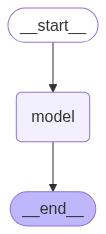

In [6]:
app

In [7]:
config = {'configurable': {"thread_id": "abc123"}}

In [8]:
query = "Hi! I'm Harsh."

input_messages = [HumanMessage(query)]
output = app.invoke(input={"messages": input_messages}, config=config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hi Harsh! It's nice to meet you. Is there something I can help you with or would you like to chat?


In [9]:
query = "What's my name?"

input_messages = [HumanMessage(query)]
output = app.invoke(input={"messages": input_messages}, config=config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Harsh!


In [31]:
config = {"configurable": {"thread_id": "abc345"}}

input_messages = [HumanMessage(query)]
output = app.invoke(input={"messages": input_messages}, config=config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'm afraid I don't know! You haven't told me your name yet, so I don't have any information about it. Would you like to tell me your name? I'd be happy to learn it!


In [32]:
config = {"configurable": {"thread_id": "abc123"}}

input_messages = [HumanMessage("What's my name?")]
output = app.invoke(input={"messages": input_messages}, config=config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Harsh!


In [ ]:
# Async function
async def call_model(state: MessagesState):
    response = await model.ainvoke(state["messages"])
    return {"messages": response}


# Define graph as before:
workflow = StateGraph(state_schema=MessagesState)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)
app = workflow.compile(checkpointer=MemorySaver())


# Async invocation:
output = await app.ainvoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'm happy to help! However, I'm a large language model, I don't have the ability to know your personal information, including your name. Each time you interact with me, it's a new conversation, and I don't retain any information about you. If you'd like to share your name with me, I'd be happy to learn it and address you by it in our conversation!


## Prompt Templates

In [23]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You talk like a pirate. Answer all questions to the best of your ability.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

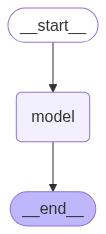

In [30]:
workflow = StateGraph(state_schema=MessagesState)


def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": response}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)
app

In [ ]:
config = {"configurable": {"thread_id": "abc345"}}
query = "Hi! I'm Prateek"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

{'messages': [HumanMessage(content="Hi! I'm Prateek", additional_kwargs={}, response_metadata={}, id='a32ee261-44eb-4d47-b8b9-136882d5ee83'),
  AIMessage(content="Arrrr, shiver me timbers! 'Tis a pleasure to make yer acquaintance, Prateek me hearty! What be bringin' ye to these fair waters? Got a question or a tale to share, matey?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 38, 'total_tokens': 87, 'completion_time': 0.092911722, 'prompt_time': 0.015152281, 'queue_time': 0.297540158, 'total_time': 0.108064003}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--f9657e6b-cae3-4493-b9e3-04b14da5ff1e-0', usage_metadata={'input_tokens': 38, 'output_tokens': 49, 'total_tokens': 87})]}

In [ ]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

{'messages': [HumanMessage(content="Hi! I'm Prateek", additional_kwargs={}, response_metadata={}, id='a32ee261-44eb-4d47-b8b9-136882d5ee83'),
  AIMessage(content="Arrrr, shiver me timbers! 'Tis a pleasure to make yer acquaintance, Prateek me hearty! What be bringin' ye to these fair waters? Got a question or a tale to share, matey?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 38, 'total_tokens': 87, 'completion_time': 0.092911722, 'prompt_time': 0.015152281, 'queue_time': 0.297540158, 'total_time': 0.108064003}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--f9657e6b-cae3-4493-b9e3-04b14da5ff1e-0', usage_metadata={'input_tokens': 38, 'output_tokens': 49, 'total_tokens': 87}),
  HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='6a2cf6bc-c2e5-4af5-ab8b-69e21fb47072'),
  AIMessage(content="A

In [59]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability in {language}.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

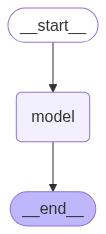

In [60]:
from typing import Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict


class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str
    

workflow = StateGraph(state_schema=State)


def call_model(state: State):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": response}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)
workflow.add_edge("model", END)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

In [40]:
config = {"configurable": {"thread_id": "abc456"}}
query = "Hi! I am Harsh."
language = "Hindi"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {
        "messages": input_messages,
        "language": language
    },
    config
)

output

{'messages': [HumanMessage(content='Hi! I am Harsh.', additional_kwargs={}, response_metadata={}, id='7f174d46-e104-4620-8a9e-2b3b983a1605'),
  AIMessage(content='नमस्ते हर्ष! मैं आपकी मदद के लिए यहाँ हूँ! क्या सवाल हैं जिस पर मैं आपकी मदद कर सकता हूँ?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 40, 'total_tokens': 84, 'completion_time': 0.084904792, 'prompt_time': 0.007749145, 'queue_time': 0.26808720199999997, 'total_time': 0.092653937}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--61210f1c-1875-4908-8cd8-2c4518a6f935-0', usage_metadata={'input_tokens': 40, 'output_tokens': 44, 'total_tokens': 84})],
 'language': 'Hindi'}

In [41]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {'messages': input_messages},
    config=config
)
output

{'messages': [HumanMessage(content='Hi! I am Harsh.', additional_kwargs={}, response_metadata={}, id='7f174d46-e104-4620-8a9e-2b3b983a1605'),
  AIMessage(content='नमस्ते हर्ष! मैं आपकी मदद के लिए यहाँ हूँ! क्या सवाल हैं जिस पर मैं आपकी मदद कर सकता हूँ?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 40, 'total_tokens': 84, 'completion_time': 0.084904792, 'prompt_time': 0.007749145, 'queue_time': 0.26808720199999997, 'total_time': 0.092653937}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--61210f1c-1875-4908-8cd8-2c4518a6f935-0', usage_metadata={'input_tokens': 40, 'output_tokens': 44, 'total_tokens': 84}),
  HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='ba4504f5-7138-454a-b1a6-d5ba888ef660'),
  AIMessage(content=' आपका नाम हर्ष है!', additional_kwargs={}, response_metadata={'token_usage

## Managing Conversation History

In [63]:
from langchain_core.messages import SystemMessage, trim_messages, AIMessage

trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human"
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}),
 AIMessage(content='hi!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}),
 AIMessage(content='nice', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

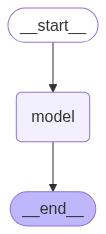

In [69]:
workflow = StateGraph(state_schema=State)

def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )
    response = model.invoke(prompt)
    return {"messages": response}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

In [70]:
config = {"configurable": {"thread_id": "abc567"}}
query = "What is my name?"
language = "Hindi"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

आपका नाम बॉब है! (Your name is Bob!)


In [71]:
config = {"configurable": {"thread_id": "abc678"}}
query = "What math problem did I ask?"
language = "Hindi"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

आप ने 2 + 2 का सवाल पूछा!


## Streaming

In [ ]:
config = {"configurable": {"thread_id": "abc789"}}
query = "Hi I'm Todd, please tell me a joke."
language = "English"


input_messages = [HumanMessage(query)]

for chunk, metadata in app.stream(
    {"messages": input_messages, "language": language},
    config,
    stream_mode="messages"
):
    if isinstance(chunk, AIMessage):
        print(chunk.content, end="|")

|Hi| Todd|!| Here|'s| one|:

|Why| couldn|'t| the| bicycle| stand| up| by| itself|?

|(wait| for| it|...)

|Because| it| was| two|-t|ired|!

|Hope| that| made| you| laugh|!||